# Setup & Configs

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
# import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from src.preprocessing import mask_water_bodies, downsample_xarray

In [2]:
# Just change the city and run all cells
city='Indore'
years = np.arange(1981, 2024 + 1, 1)

In [3]:

from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_scale", ['blue', 'cyan', 'green', 'yellow', 'red'])

# Data

In [4]:
# Load boundary shapefile
from src.gee_utils import load_roi
roi_gdf, extent = load_roi(city)

In [5]:
# Load dataset
ds = xr.open_dataset('../data/merged_data/Indore_raw.nc4')
ds = mask_water_bodies(ds)

ds = downsample_xarray(ds, target_pixels=200)

In [6]:
# Target
y = ds['risk'].sel(time=slice(1981, 2024)).values

# Split

In [7]:
# Train/Test Split
test_size = 0.25
split_idx = int(len(years) * (1 - test_size))

print('Split year:', years[split_idx])

Split year: 2014


In [ ]:
# Validation Splits

# Metrics

In [49]:
from src.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# For weighted metrics - penalize high risk pixels
weights = np.percentile(y, 95, axis=0) ** 2

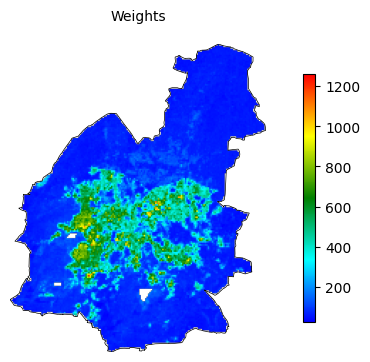

In [9]:

plt.figure(figsize=(4, 4))
img = plt.imshow(weights, cmap=custom_cmap, extent=extent, origin='upper')
roi_gdf.boundary.plot(ax=plt.gca(), color='black', lw=0.5)

plt.colorbar(img, fraction=0.04, pad=0.12)
plt.title('Weights', fontsize=10, y=1.05)
plt.axis('off')
plt.show()

# Linear model baseline

In [ ]:
# Target
y_train, y_test = np.split(y, [split_idx])

# Input features - years only
X_train, X_test = np.split(years.reshape(-1, 1), [split_idx])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin

class LinearTrendModel(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.params = params
    
    def fit(self, X, y):
        self.output_shape_ = y.shape[1:]
        
        y_flat = y.reshape(y.shape[0], -1)
        self.roi_mask_ = ~np.isnan(y_flat).all(axis=0)
        y_valid = y_flat[:, self.roi_mask_]
        
        self.models_ = []
        for y_lr in y_valid.T:
            model = LinearRegression(**self.params)
            model.fit(X, y_lr)
            self.models_.append(model)
        
        return self
    
    def predict(self, X):
        n_samples = X.shape[0]
        n_pixels = np.prod(self.output_shape_)
        
        y_pred = np.full((n_samples, n_pixels), np.nan)
        y_pred[:, self.roi_mask_] = np.column_stack([model.predict(X) for model in self.models_])
        
        return y_pred.reshape((n_samples,) + self.output_shape_)

In [14]:
model = LinearTrendModel()
model.fit(X_train, y_train)

LinearTrendModel()

In [15]:
# Global metrics - Training
print('RMSE:', root_mean_squared_error(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))
print('MAE:', mean_absolute_error(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))
print('R2:', r2_score(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))

RMSE: 1.6503569305556278
MAE: 1.1893184724318937
R2: 0.9079542244918893


In [16]:
# Global metrics - Testing
print('RMSE:', root_mean_squared_error(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))
print('MAE:', mean_absolute_error(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))
print('R2:', r2_score(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))

RMSE: 2.961617978122288
MAE: 2.186177114939381
R2: 0.8173843990951355


# Linear tree model

In [9]:
# Preprocess Input Features
X = ds.drop_vars('risk')

## Expand static features
for var in ['dem', 'ndvi', 'ndwi', 'tpi', 'distance']:
    X[var] = X[var].expand_dims(time=X.time)

## Forward fill population
X['population'] = X['population'].ffill(dim='time')
X = X.sel(time=slice(1981, 2024))

## Rolling mean values for rainfall and runoff
X['rainfall_mov5'] = X['rainfall'].rolling(time=5, min_periods=1).mean(skipna=True).shift(time=1).fillna(X['rainfall'].sel(time=1981))
X['runoff_mov5'] = X['runoff'].rolling(time=5, min_periods=1).mean(skipna=True).shift(time=1).fillna(X['runoff'].sel(time=1981))

## Time feature
time_da = xr.DataArray(X['time'].values, dims='time', name='time').expand_dims({'variable': ['time']})

# Merge dataset
X = xr.concat([X[['dem', 'ndvi', 'ndwi', 'tpi', 'distance', 'population', 'rainfall_mov5', 'runoff_mov5']].to_array(), time_da],
              dim='variable')
X = X.transpose('time','y','x','variable')

In [10]:
# Target
y_train, y_test = np.split(y, [split_idx])

# Input features - years only
X_train, X_test = np.split(X.values, [split_idx], axis=0)

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class SpatialRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_model, **params):
        self.base_model = base_model
        self.params = params
    
    def fit(self, X, y):
        self.output_shape_ = y.shape[1:]
        
        self.roi_mask_ = ~np.isnan(y).all(axis=0).ravel()
        
        X_flat = X.reshape(X.shape[0], -1, X.shape[-1])
        y_flat = y.reshape(y.shape[0], -1)

        X_roi = X_flat[:, self.roi_mask_, :].reshape(-1, X.shape[-1])
        y_roi = y_flat[:, self.roi_mask_].reshape(-1)

        self.model_ = clone(self.base_model(**self.params))
        self.model_.fit(X_roi, y_roi)
        return self
    
    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1, X.shape[-1])
        y_pred = np.full((X.shape[0], np.prod(self.output_shape_)), np.nan)

        X_roi = X_flat[:, self.roi_mask_, :].reshape(-1, X.shape[-1])

        y_pred[:, self.roi_mask_] = self.model_.predict(X_roi).reshape(X.shape[0], -1)

        return y_pred.reshape((X.shape[0],) + self.output_shape_)

In [15]:
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

model = SpatialRegressor(
    LinearTreeRegressor,
    **{
        'base_estimator': LinearRegression(),
        'split_features': [0, 1, 2, 3, 4, 5, 6, 7],
        'linear_features': [5, 6, 7, 8],
        'n_jobs': -1
    }
)
model.fit(X_train, y_train)

SpatialRegressor(base_model=<class 'lineartree.lineartree.LinearTreeRegressor'>)

In [17]:
# Global metrics - Training
print('RMSE:', root_mean_squared_error(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))
print('MAE:', mean_absolute_error(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))
print('R2:', r2_score(y_train, model.predict(X_train), axis=None, sample_weight=np.broadcast_to(weights, y_train.shape)))

RMSE: 1.7197677735012706
MAE: 1.207652374565673
R2: 0.9000488692887861


In [19]:
# Global metrics - Testing
print('RMSE:', root_mean_squared_error(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))
print('MAE:', mean_absolute_error(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))
print('R2:', r2_score(y_test, model.predict(X_test), axis=None, sample_weight=np.broadcast_to(weights, y_test.shape)))

RMSE: 2.4511568115603506
MAE: 1.845528625016068
R2: 0.8749101726699238
